In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import getpass
%matplotlib inline

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="root",
                       passwd=getpass.getpass(),
                       db="olist")

········


# Time Series

We start by looking at a crucial component of our business - the number of incoming orders

## No. of Orders

I want to have the date as a date id and number of orders, after 2017-0-01

|  date_id  |number of orders  |
|-----------|------------------|
| 2017-01-2 | 83737|

In [3]:
daily_orders_query = """
SELECT 
    DATE(order_purchase_timestamp)  AS date_id,
    COUNT(order_id)                 AS no_of_orders
FROM olist.orders o 
WHERE order_purchase_timestamp > '2017-01-01'
GROUP BY 1
ORDER BY 1
"""
daily_orders = pd.read_sql(daily_orders_query, conn)

In [4]:
daily_orders.head()

,date_id,no_of_orders
0,2017-01-05,32
1,2017-01-06,3
2,2017-01-07,5
3,2017-01-08,6
4,2017-01-09,5


In [5]:
daily_orders.dtypes

date_id         object
no_of_orders     int64
dtype: object

In [6]:
daily_orders["date_id"] = pd.to_datetime(daily_orders["date_id"])

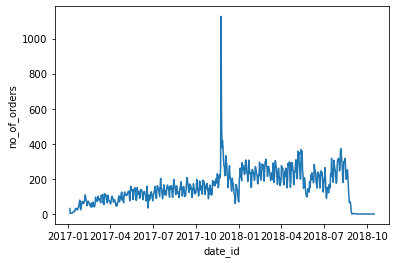

In [7]:
sns.lineplot(data=daily_orders,
             x="date_id",
             y="no_of_orders");

Too much detail - next we can try to look at the per week data!

In [8]:
weekly_orders = daily_orders.copy()

In [9]:
#one way to get week number
weekly_orders = weekly_orders.assign(week_id=weekly_orders["date_id"].dt.isocalendar().week)

In [10]:
weekly_orders.head()

,date_id,no_of_orders,week_id
0,2017-01-05,32,1
1,2017-01-06,3,1
2,2017-01-07,5,1
3,2017-01-08,6,1
4,2017-01-09,5,2


Here we will look at another way to get the week information. Instead of looking specifically at the week_id, we will try to force every week back to the first day of the week. We will do this by subtracting the day of the week from the date_id. 

In [11]:
weekly_orders = weekly_orders.assign(day_of_week=weekly_orders["date_id"].dt.dayofweek)

In [12]:
weekly_orders = weekly_orders.assign(week_year=weekly_orders["date_id"] 
                                     - pd.to_timedelta(weekly_orders["date_id"]
                                                       .dt.dayofweek, unit="D"))

In [13]:
weekly_orders.head()

,date_id,no_of_orders,week_id,day_of_week,week_year
0,2017-01-05,32,1,3,2017-01-02
1,2017-01-06,3,1,4,2017-01-02
2,2017-01-07,5,1,5,2017-01-02
3,2017-01-08,6,1,6,2017-01-02
4,2017-01-09,5,2,0,2017-01-09


If we wanted to continue to use `week_id` we would need to add the year. For now, we will continue on with the `week_year` column.

In [14]:
weekly_orders = (weekly_orders.groupby("week_year")
                              .agg({"no_of_orders":"sum"})
                              .reset_index())

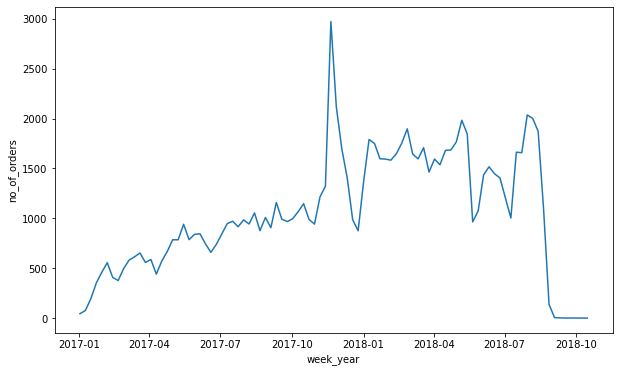

In [15]:
fig, ax = plt.subplots(figsize=(10,6)) #used matplotlib to change fig size
sns.lineplot(data=weekly_orders,
             x="week_year",
             y="no_of_orders");

A bit better than per day, but maybe per month would be better. There is still more variance than necessary.

In [16]:
monthly_orders = daily_orders.copy()

In [17]:
monthly_orders.head()

,date_id,no_of_orders
0,2017-01-05,32
1,2017-01-06,3
2,2017-01-07,5
3,2017-01-08,6
4,2017-01-09,5


In [18]:
monthly_orders.dtypes

date_id         datetime64[ns]
no_of_orders             int64
dtype: object

In [19]:
#in order to have a datetime object, we need to have a day
monthly_orders = (monthly_orders
                  .assign(month_id=pd.to_datetime(monthly_orders["date_id"].dt.strftime("%Y-%m-01")))
                  .groupby("month_id")
                  .agg({"no_of_orders":"sum"})
 #                       "other_column":"count",
#                        "other_column": np.sum})
                  .reset_index())

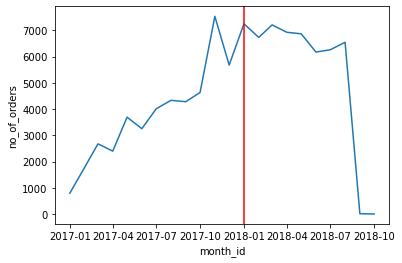

In [20]:
ax = sns.lineplot(data=monthly_orders,
             x="month_id",
             y="no_of_orders");
ax.axvline(pd.to_datetime("2018-01-01"), color="r");

2017 is mostly rising, 2018 is plateauing or decreasing slightly.

Number of orders in each month, by year:

| year | month | no_of_orders|
|------|-------|-------------|
| 2017 | 1     | 239470      |

In [21]:
monthly_orders

,month_id,no_of_orders
0,2017-01-01,798
1,2017-02-01,1780
2,2017-03-01,2678
3,2017-04-01,2402
4,2017-05-01,3695
5,2017-06-01,3256
6,2017-07-01,4013
7,2017-08-01,4337
8,2017-09-01,4285
9,2017-10-01,4636


In [22]:
monthly_orders["month_id"].dt.year

0     2017
1     2017
2     2017
3     2017
4     2017
5     2017
6     2017
7     2017
8     2017
9     2017
10    2017
11    2017
12    2018
13    2018
14    2018
15    2018
16    2018
17    2018
18    2018
19    2018
20    2018
21    2018
Name: month_id, dtype: int64

In [23]:
monthly_orders["month_id"].dt.month

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12     1
13     2
14     3
15     4
16     5
17     6
18     7
19     8
20     9
21    10
Name: month_id, dtype: int64

In [24]:
monthly_orders = (monthly_orders.assign(year=monthly_orders["month_id"].dt.year)
                .assign(month=monthly_orders["month_id"].dt.month))

In [25]:
#exclude where months are incomplete
monthly_orders = monthly_orders.loc[monthly_orders["month_id"] < "2018-09-01"]

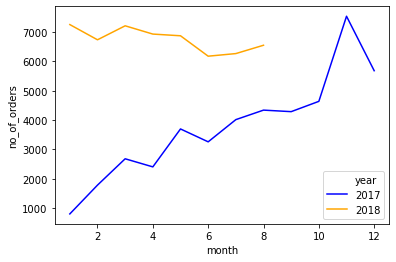

In [26]:
sns.lineplot(data=monthly_orders,
             x="month",
             y="no_of_orders",
             hue="year",
             palette=["blue", "orange"]);

- 2018 is doing better than 2017
- 2017 is a year of growth, so they are building up the business and have spikes in holiday seasons
- 2018 could be a stabilizing year - could go up again aroud Q3 or Q4 but we cant see

yoy - year over year
mom - month over month

Show the same graph for other metrics

Number of orders, Number of Sellers, Number of items sold, and Revenue 
- after 2017-01-01 before 2018-09-01
| month | year | orders | items_sold | sellers |revenue |
|-------|------|--------|-----------|----------|---------|

In [27]:
monthly_perf_query = """
SELECT 
    YEAR(o.order_purchase_timestamp)        AS year,
    MONTH(o.order_purchase_timestamp)       AS month, 
    COUNT(DISTINCT o.order_id)              AS orders,
    SUM(1)                                  AS items_sold,
    COUNT(DISTINCT oi.seller_id)            AS sellers,
    SUM(oi.price)                           AS revenue
FROM olist.orders o
    INNER JOIN olist.order_items oi 
    ON o.order_id = oi.order_id 
WHERE o.order_purchase_timestamp >= '2017-01-01'
    AND o.order_purchase_timestamp < '2018-09-01'
GROUP BY 1, 2
"""

In [28]:
month_perf = pd.read_sql(monthly_perf_query, conn)

In [29]:
month_perf

,year,month,orders,items_sold,sellers,revenue
0,2017,1,787,952.0,227,1.198089e+05
1,2017,2,1733,1952.0,427,2.476922e+05
2,2017,3,2637,2996.0,499,3.736766e+05
3,2017,4,2389,2682.0,506,3.599871e+05
4,2017,5,3655,4128.0,583,5.047740e+05
5,2017,6,3228,3597.0,541,4.348993e+05
6,2017,7,3956,4501.0,604,4.968049e+05
7,2017,8,4300,4922.0,708,5.740459e+05
8,2017,9,4242,4827.0,730,6.248995e+05
9,2017,10,4573,5329.0,776,6.645821e+05


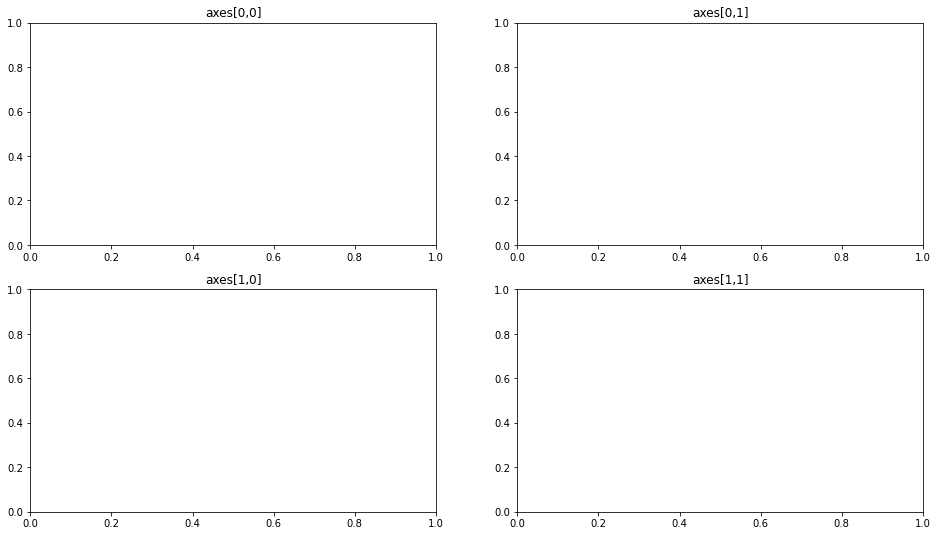

In [30]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                        figsize=(16,9))
axes[0,0].set_title("axes[0,0]");
axes[1,0].set_title("axes[1,0]");
axes[0,1].set_title("axes[0,1]");
axes[1,1].set_title("axes[1,1]");

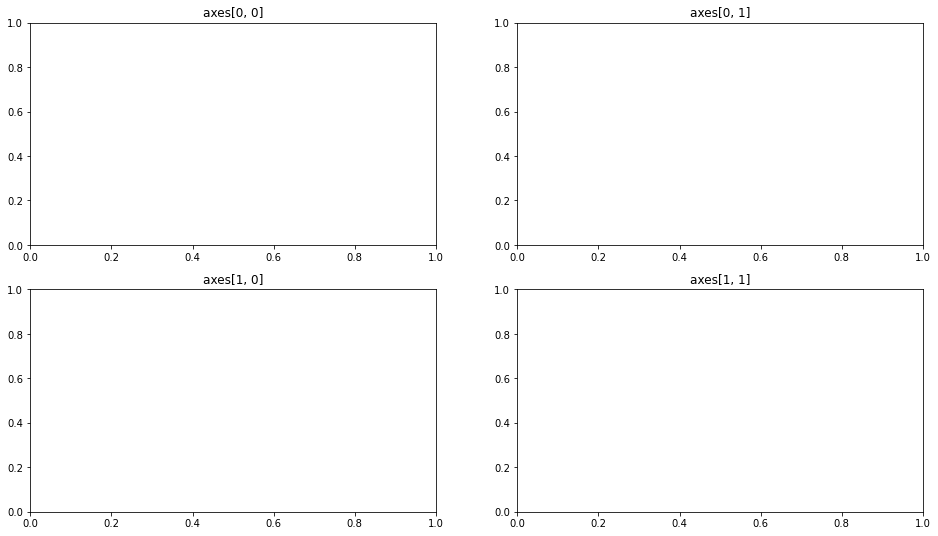

In [31]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                        figsize=(16,9))
for i in range(2):
    for j in range(2):
        axes[i,j].set_title(f"axes[{i}, {j}]")

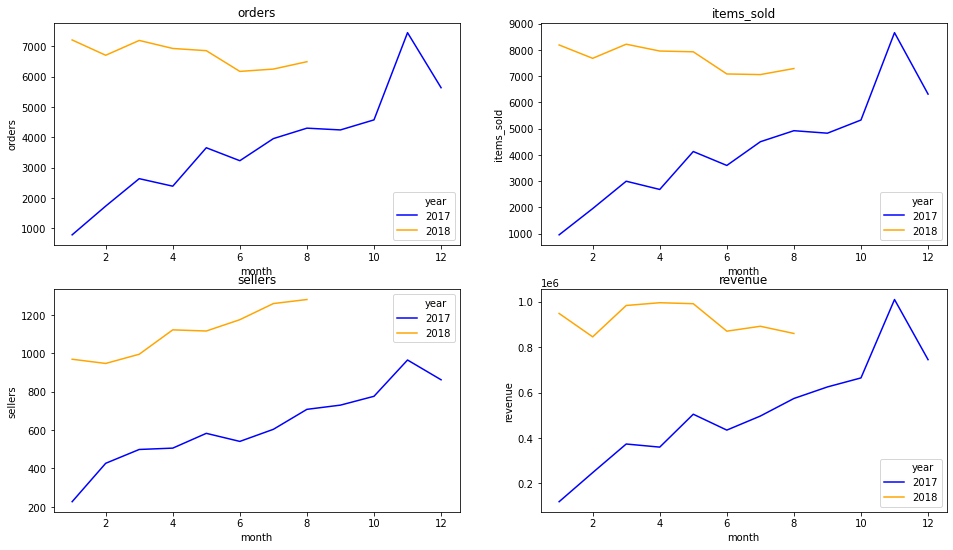

In [32]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                        figsize=(16,9))
metrics = ["orders", "items_sold", "sellers", "revenue"]
i = 0
for ax in axes.flatten():
    sns.lineplot(data=month_perf,
             x="month",
             y=metrics[i],
             hue="year",
             palette=["blue", "orange"],
            ax=ax);
    ax.set_title(metrics[i])
    i+=1

- Everything is relatively proportional in 2017
- In 2018 - are have more sellers, but they seem to be selling less
- items sold per order seems to be pretty consistant

In order to take a closer look and confirm what we are seeing, we will now plot:
- items sold per order
- items sold per seller
- revenue per item sold

In [33]:
month_perf = (month_perf
 .assign(items_per_order=month_perf["items_sold"] / month_perf["orders"])
 .assign(items_per_seller=month_perf["items_sold"]/month_perf["sellers"])
 .assign(revenue_per_item=month_perf["revenue"] / month_perf["items_sold"]))

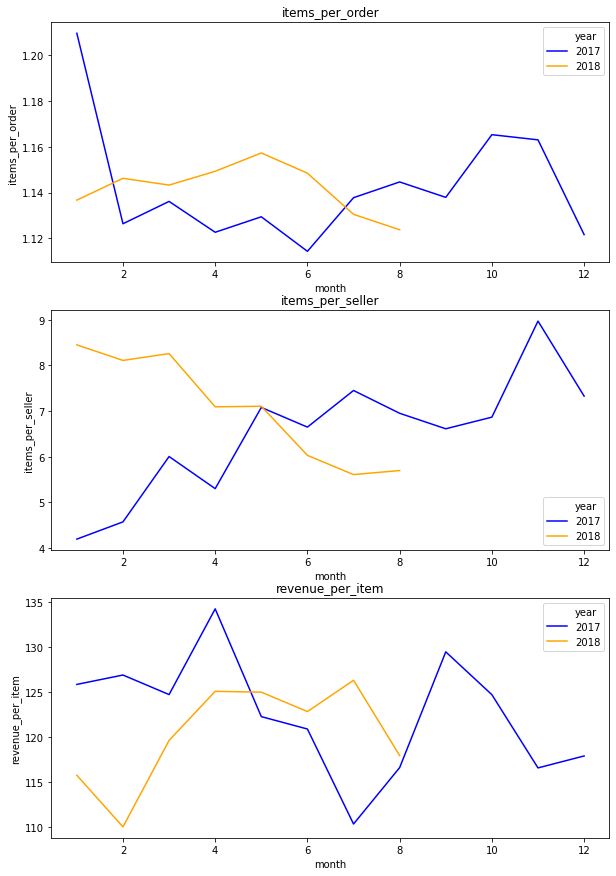

In [34]:
fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(10,15))
ratios = ["items_per_order", "items_per_seller", "revenue_per_item"]
i = 0
for ax in axes:
    sns.lineplot(data=month_perf,
        x="month",
        y=ratios[i],
        hue="year",
        palette=["blue", "orange"],
        ax=ax);
    ax.set_title(ratios[i])
    i+=1

From these graphs, we can see that the average number of tiems per order has been prety constant. Hwoever, looking at the sellers, it suggests that there are actually more unique sellers selling less items (on average). We can also see that monthly revenue has been mostly constant. Therefore, the revenue we generate for each order or item increase over time. The most concerning development is the number of order or items sold. 

To look at this further, we will dig into where are our orders going.

# Take a closer look at orders

## Split order by customer state

- after 2017-01-01 and before 2018-09-01

| month_id | customer_state | number of order |
|----------|----------------|-----------------|
|2017-01-01| SP             | 398             |
|2017-01-01| BA             | 98              |

In [35]:
order_by_state_query = """
SELECT 
	DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS month_id,
	c.customer_state,
	COUNT(*)											AS orders
FROM olist.orders o
	INNER JOIN olist.customers c 
	ON o.customer_id = c.customer_id 
WHERE o.order_purchase_timestamp BETWEEN CAST('2017-01-01' AS DATE) 
	AND CAST('2018-09-01' AS DATE)
GROUP BY c.customer_state,
		 month_id
ORDER BY 
	month_id, 
	customer_state
"""
order_by_state = pd.read_sql(order_by_state_query, conn)

In [36]:
order_by_state.head()

,month_id,customer_state,orders
0,2017-01-01,AC,2
1,2017-01-01,AL,1
2,2017-01-01,BA,25
3,2017-01-01,CE,9
4,2017-01-01,DF,13


In [37]:
order_by_state["month_id"] = pd.to_datetime(order_by_state["month_id"])

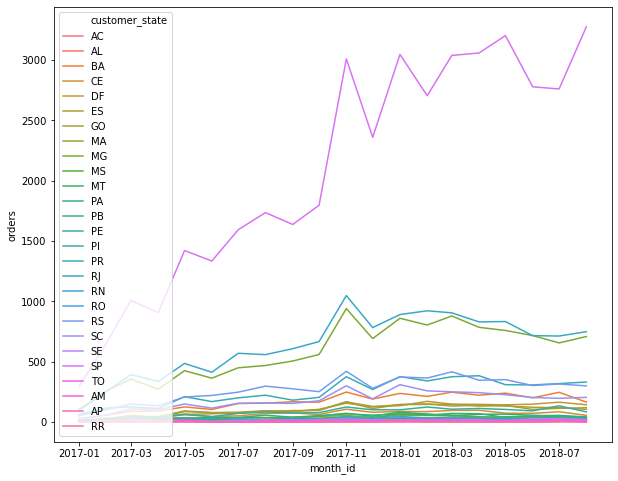

In [38]:
fig, ax = plt.subplots(figsize=(10,8))

sns.lineplot(data=order_by_state,
            x="month_id",
            y="orders",
            hue="customer_state");

### Continuing after Lecture
- We now want to remove the detail from the smaller states
- the goal will be to have informationa about our top 5 states (as of 2018-08-01) and have the rest put into one group called other

In [39]:
top_5_states = list(
                #want to have our final output as a list
                order_by_state.loc[order_by_state["month_id"] == "2018-08-01"]
                #only getting the values for the date we want
                .sort_values("orders", ascending=False)
                #order the values
                ["customer_state"] #select only the customer states
                [:5] #select the top 5
                .values #get the actual states
)

In [40]:
top_5_states

['SP', 'RJ', 'MG', 'PR', 'RS']

In [41]:
#look at how we could create an empty column that we want to fill with the state
#or other
order_by_state.assign(grouped_customer_state=np.nan)

,month_id,customer_state,orders,grouped_customer_state
0,2017-01-01,AC,2,NaN
1,2017-01-01,AL,1,NaN
2,2017-01-01,BA,25,NaN
3,2017-01-01,CE,9,NaN
4,2017-01-01,DF,13,NaN
...,...,...,...,...
528,2018-08-01,RS,301,NaN
529,2018-08-01,SC,206,NaN
530,2018-08-01,SE,23,NaN
531,2018-08-01,SP,3275,NaN


In [42]:
#next step would be to immediately add values to this column instead of nans
order_by_state.assign(grouped_customer_state=np.where(order_by_state["customer_state"]
                                                      .isin(top_5_states),
                                                     order_by_state["customer_state"],
                                                     "Other")).head(26)

#np.where(some condition that needs to be met, what to put if that condition is met, 
#what to use otherwise)
#another way to think about it is - if "condition met", then "use this", else "use this"

,month_id,customer_state,orders,grouped_customer_state
0,2017-01-01,AC,2,Other
1,2017-01-01,AL,1,Other
2,2017-01-01,BA,25,Other
3,2017-01-01,CE,9,Other
4,2017-01-01,DF,13,Other
5,2017-01-01,ES,12,Other
6,2017-01-01,GO,18,Other
7,2017-01-01,MA,9,Other
8,2017-01-01,MG,107,MG
9,2017-01-01,MS,1,Other


In [43]:
#now that we have validated this, we can save it as a column
order_by_state = order_by_state.assign(grouped_customer_state=np.where(order_by_state["customer_state"]
                                                      .isin(top_5_states),
                                                     order_by_state["customer_state"],
                                                     "Other"))

In [44]:
#we can then create our groups and aggregate, using a new dataframe so it 
#doesn't group our order_by_state df
order_by_gr_state = (order_by_state.groupby(["month_id", "grouped_customer_state"])
                                   .agg({"orders":"sum"})
                                   .reset_index())

In [45]:
order_by_gr_state.head(10)

,month_id,grouped_customer_state,orders
0,2017-01-01,MG,107
1,2017-01-01,Other,176
2,2017-01-01,PR,65
3,2017-01-01,RJ,97
4,2017-01-01,RS,54
5,2017-01-01,SP,299
6,2017-02-01,MG,260
7,2017-02-01,Other,390
8,2017-02-01,PR,118
9,2017-02-01,RJ,254


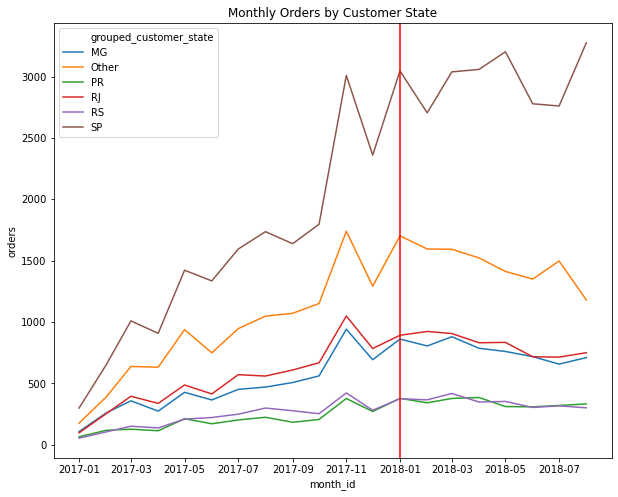

In [48]:
fig, ax = plt.subplots(figsize=(10,8))

sns.lineplot(data=order_by_gr_state,
             x="month_id",
             y="orders",
             hue="grouped_customer_state",
             ax=ax).set_title("Monthly Orders by Customer State");
ax.axvline(pd.to_datetime("2018-01-01"), color="r");

The graph suggests that orders placed by customers in Sao Paolo did not decrease as much as in other states. 

-> There may be a relationship between orders over time and the time it takes to deliever those orders, since we have our distribution center in Sao Paolo.

We can test this hypothesis by looking at the average number of days it takes fro delievering the orders to the customers, grouped by states for 2018.

In [49]:
avg_dd_per_state_query = """
SELECT 
    c.customer_state,
    AVG(DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp)) AS avg_delievery_days
FROM olist.orders o
    JOIN olist.customers c
    ON o.customer_id = c.customer_id
WHERE order_status = 'delivered'
    AND order_purchase_timestamp > '2018-01-01'
GROUP BY c.customer_state;

"""

avg_gg_per_state = pd.read_sql(avg_dd_per_state_query, conn)

In [50]:
avg_gg_per_state.sort_values("avg_delievery_days")

,customer_state,avg_delievery_days
0,SP,8.2469
10,PR,11.5688
3,MG,11.8311
9,DF,12.4132
8,SC,14.5398
4,GO,15.1423
1,RS,15.2724
5,RJ,15.7214
14,MS,16.2117
17,ES,16.2254


Within the top 8 states based on the lowest delievery time, 5 of our top states based on orders are present. This is an indication that we might be right. We can further dig into this by plotting a scatterplot that may indicate a correlation between a states decline in orders and their average delievery time!

- a good homework question if you want to look into it!